## Libraries and Packages used

In [2]:
# import required libraries 
import urllib.request # # urllib library used to retrieve the content from a url
from bs4 import BeautifulSoup # bs4 used for pulling data from html or xml file with the help of a parser
import nltk
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import json
import numpy as np
import pandas as pd
import math
import time
import re
from collections import Counter
import requests

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import numpy as np
import warnings
%matplotlib inline

In [4]:
test_file = "QA_Pair_testing_file.txt"
f = open(test_file, "rb")
lines = f.readlines()

questions = []
answers = []
for line in lines:
    line = line.decode()
    line = line.strip()
    qa = line.split(":::")
    questions.append(qa[1])
    answers.append(qa[0])

# Question Classification

In [5]:
file_name = "Pre_tagged_labelled_data.txt"
f = open(file_name , 'rb')
labels_list = []
queries_list = []
for each in f:
#     print(each)
    each = each.decode()
    each = each.strip()
#     print(each)
    l = len(each.split(":"))
    labels_list.append(str(each.split(":")[0]))
    if(l==2):
        queries_list.append(str(each.split(":")[1]))
    else:
        queries_list.append(':'.join(each.split(":")[1:]))

In [6]:
obj = {
    "Question":queries_list,
    "Label": labels_list
}
df = pd.DataFrame(data = obj )
#print(df.head())
# df.to_excel("final_data.xlsx")

In [7]:
X = df["Question"].values
Y = df["Label"].values
X_train ,X_test ,Y_train ,Y_test = train_test_split(X,Y,test_size=0.2, random_state=20)

In [8]:
vectorizer = TfidfVectorizer()
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

# print(vectorizer.get_feature_names())
print("Train_data shape :",X_train_tf.shape , Y_train.shape)
print("Test_data shape  :",X_test_tf.shape , Y_test.shape)

Train_data shape : (1073, 913) (1073,)
Test_data shape  : (269, 913) (269,)


In [9]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_test = encoder.transform(Y_test)

In [10]:
model = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(100,80,50,8),random_state=4,alpha=0.1,batch_size=71)
model.fit(X_train_tf,Y_train)

MLPClassifier(alpha=0.1, batch_size=71, hidden_layer_sizes=(100, 80, 50, 8),
              random_state=4)

In [11]:
test_pred = model.predict(X_test_tf)

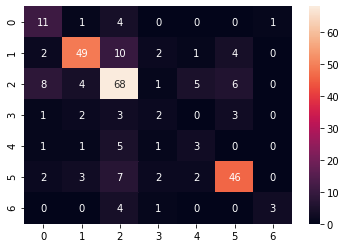

In [12]:
k = confusion_matrix(Y_test,test_pred)
sns.heatmap(k , annot=True , fmt='d')
plt.show()

In [14]:
print(encoder.inverse_transform([0,1,2,3,4,5,6]))

['DATE' 'LOCA' 'NUMB' 'ORGA' 'PERC' 'PERS' 'TIME']


In [13]:
correctly_classified_count = 0
for i in range(len(Y_test)):
    if(Y_test[i]==test_pred[i]):
        correctly_classified_count+=1
print("Accuracy on test data : {0}".format(correctly_classified_count/len(Y_test)))

Accuracy on test data : 0.6765799256505576


<h2> Final_model : </h2>

In [12]:
def Query_category(query):    
    x_ = np.array([query])
    x_tf = vectorizer.transform(x_)
    prediction = model.predict(x_tf)
    return encoder.inverse_transform(prediction)

In [14]:
# import urllib2
def query_translation(query):
    agents = {'User-Agent':"Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322; .NET CLR 2.0.50727; .NET CLR 3.0.04506.30)"}
    query = query.strip()
    query = query.replace(" ", "+")
    link = "https://translate.google.com/m?hl=en&sl=te&tl=en&ie=UTF-8&prev=_m&q={0}".format(query)
    #print(link)
    try:
        conten = requests.get(link, headers=agents, timeout=5).content
        soup = BeautifulSoup(conten,'lxml')
        tr = soup.find("div","t0")
    except: #ConnectionError or read timout error
        time.sleep(4)
        try:
            conten = requests.get(link, headers=agents,  timeout=5).content
            soup = BeautifulSoup(conten,'lxml')
            tr = soup.find("div","t0")
        except Exception as e: #RemoteDisconnected
            print("exception in query translation",e)
            return "fail" 
    return tr.text

In [15]:
# import urllib2
def ans_translation(ans):
    agents = {'User-Agent':"Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322; .NET CLR 2.0.50727; .NET CLR 3.0.04506.30)"}
    ans = ans.strip()
    ans = ans.replace(" ", "+")
    link = "https://translate.google.com/m?hl=en&sl=en&tl=te&ie=UTF-8&prev=_m&q={0}".format(ans)
    #print(link)
    try:
        conten = requests.get(link, headers=agents , timeout=5).content
        soup = BeautifulSoup(conten,'lxml')
        tr = soup.find("div","t0")
    except: # ConnectionError or read time out error
        time.sleep(4)
        try:
            conten = requests.get(link, headers=agents , timeout=5).content
            soup = BeautifulSoup(conten,'lxml')
            tr = soup.find("div","t0")
        except Exception as e: #RemoteDisconnected
            print("exception in answer translation",e)
            return "UNABLE TO FIND"
    return tr.text

In [17]:
def query_url_generation(query, search_engine):
    # Function to generate url from a query

    query = str(query).strip()
    query = query.lower() # transform given query into lowercase
    query = query.replace(' ', '+') # google/bing removes spaces and adds + symbol for url generation for a query

    # URL generation
    return 'https://' + search_engine + '/search?q=' + query

In [18]:
def g_search(input_query , no_of_urls):
    url = "https://www.google.com/search?q="+input_query
    main_url = url +"&sxsrf=ALeKk03rVTWzT8epO1h0KE90ax9RrBcG5Q:1590835001614&ei=OTfSXv-PJfGH4-EPrs2fkAQ&start=&sa=N&ved=2ahUKEwi_kKuZstvpAhXxwzgGHa7mB0IQ8NMDegQIJBA1&safe=active"
    start_pos = main_url.find('start=')
    p = start_pos+6
    no_of_pages = math.ceil(no_of_urls/10)
    count = 0
    links_list = []
    for i in range(0,no_of_pages):
            try:
                res = requests.get(url)
            except Exception as e:
                time.sleep(3)
                try:
                    res = requests.get(url)
                except:
                    time.sleep(6)
                    res = requests.get(url)
                print("exception {0} occured".format(e))
            #print("response status : {0} ".format(res.status_code))
            while(res.status_code==429):
                time.sleep(3)
                res = requests.get(url)
            soup = BeautifulSoup(res.text , "lxml")
            g_results_div = soup.find_all('div' , attrs={'class':'ZINbbc xpd O9g5cc uUPGi'})
            for each in g_results_div:
                try:
                    li = each.find('a' , href=True)
                    link = li['href']
                    link = str(link).split("&")[0]
                    link = link.replace("/url?q=","")
                    if (link.startswith("https://")):
                        #print(link)
                        links_list.append(link)
                except:
                    pass
                #print("***************************************************\n")
            count+=1
            #print("page completed {0}".format(count))
            url = main_url[:p] + str(count*10) + main_url[p:]
            #time.sleep(2)
    return links_list

In [19]:
def bing_search(input_query , no_of_urls):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'}
    input_query =  input_query.replace(" ","+")
    url = "https://www.bing.com/search?q="+input_query
    main_url = url+"&qs=HS&pq=who+is+the+pre&sc=8-14&cvid=AF7CFE3BF58449DB869F3D9A187C5222&sp=1&first=&FORM=PERE1"
    first_pos = main_url.find('first=') 
    p = first_pos + 6
    #print(url)
    no_of_pages = math.ceil(no_of_urls/10)
    count = 0
    bing_links = []
    for each in range(0,no_of_pages):
        res = requests.get(url,headers=headers)
        #print(res.status_code)
        while(res.status_code == 429):
            res = requests.get(url,headers=headers)
        soup = BeautifulSoup(res.content , "lxml")
        #print(soup.prettify())
        b_r_div = soup.find_all('li' ,  attrs = {'class':'b_algo'})
        for each in b_r_div:
            h  = each.find('h2')
            link = h.find('a', href=True)
            #print(link['href'])
            bing_links.append(link['href'])
        #print(len(bing_links))
        count+=1
        #print("page completed {0}".format(count))
        url =  main_url[:p] + str(count*10) + main_url[p:]
        time.sleep(2)
    return bing_links

In [20]:
def non_ascii(text):
    return  "".join([i if ord(i)<128 else " " for i in text])

In [21]:
def from_text_to_vec(text):
    WORD = re.compile(r"\w+")
    words = WORD.findall(text)
    return Counter(words)

In [22]:
def get_cosine(vect1, vect2):
    intersection = set(vect1.keys()) & set(vect2.keys())
    nume = sum([vect1[x] * vect2[x] for x in intersection])
    
    sum1 = sum([vect1[x]**2 for x in vect1.keys()])
    sum2 = sum([vect2[x]**2 for x in vect2.keys()])
    denom = math.sqrt(sum1) * math.sqrt(sum2)
    #print(intersection)
    if not denom:
        return 0.0
    else:
        return nume/denom

In [24]:
def extract_data(links_list):
    full_text = " "
    for each in links_list:
        print(each)
        text = " "
        if(each.endswith(".pdf") or each.endswith(".ppt")):
            pass
        else:
            try:
                try:
                    response = requests.get(each , timeout=5)
                except requests.exceptions.ConnectionError:
                    time.sleep(2)
                    response = requests.get(each , timeout=5)
                print("extract_data response code : {0}".format(response.status_code))
                each_soup = BeautifulSoup(response.content,'html.parser')
                #print(each_soup)
                for p in each_soup.find_all("p"):
                    text+= p.text + " "
                full_text+=text
            except Exception as e:
                print("exception",e)
                print("{0} url max retries".format(each))
            time.sleep(2)
    return full_text

In [25]:
def sent_tokenization(full_text):
    
    ## sent-tokenization
    sent_tok = re.split('[.?:;]+',full_text)
    
    return sent_tok

In [26]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords_list= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [27]:
def sent_preprocess(x):
    x = non_ascii(x)
    x = str(x).strip()
    x = x.replace("\n"," ")
    x = x.replace("\t"," ")
    x = x.replace("\r"," ")
    res = re.sub("[\(\[].*?[\)\]]", "", x)   ### Removes '[anything], (anytext)'
    s = res.replace("_"," ")
    s = res.replace("-"," ")
    s = s.replace("!"," ")
    s = s.replace("?"," ")
    s = s.replace("\\"," ")
    s = s.replace("("," ")
    s = s.replace(")"," ")
    s = s.replace("["," ")
    s = s.replace("]"," ")
    s = s.strip()
    return s

In [28]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
def ans_preprocess(query_cat,best_answers):
    final_answer_dict = {}
    if query_cat=="NUMB":
        #best_answers = {"six":1,"6":3,"233":5}
        for key,value in best_answers.items():
            if(key=="one"):
                key='1'
            elif(key=="two"):
                key = '2'
            elif(key=="three"):
                key = '3'
            elif(key=="four"):
                key = '4'
            elif(key=="five"):
                key = '5'
            elif(key=="six"):
                key = "6"
            elif(key=="seven"):
                key = '7'
            elif(key=="eight"):
                key = '8'
            elif(key=="nine"):
                key = '9'
            elif(key=="zero"):
                key = '0'
            if key not in final_answer_dict:
                final_answer_dict[key] = value
            else:
                final_answer_dict[key]+=value
    return final_answer_dict

In [30]:
def sort(s, n): 
    for i in range(1, n): 
        temp = s[i] 
        j = i - 1
        while j >= 0 and len(temp) < len(s[j]): 
            s[j + 1] = s[j] 
            j -= 1

        s[j + 1] = temp 
        
    return s

In [31]:
def best_answer_processing_for_per(best_answers):
    new_t1 = []
    t1 = best_answers
    for each in t1:
        new_t1.append((each[0].lower(),each[1]))
    new_t1 = (dict(new_t1))

    #print("*************************************************")
    t1_keys = []
    for each in t1:
        t1_keys.append(each[0].lower())
    t1_keys = sorted(list(set(t1_keys)))

    #print("*************************************************")

    arr = t1_keys
    n = len(arr)  
    sorted_array = (sort(arr, n))

    #print("**************************************************")

    unique = sorted_array
    n = 0
    for i in range(len(unique)):
        n = i+1
        for j in range(n,len(unique)):
            a = unique[i]
            b = unique[j]
            v1 = from_text_to_vec(a)
            v2 = from_text_to_vec(b)
            cos = get_cosine(v1,v2)
            if cos > 0:
                #print({a:b})
                #print(cos)
                a_new = a.replace(" ","")
                b_new = b.replace(" ","")
                if len(a) < len(b):
                    max_st = b
                    min_st = a
                else:
                    max_st = a
                    min_st = b
                if (a in b) or (b in a):
                    try:
                        new_t1[max_st] += abs(new_t1[max_st] - new_t1[min_st])
                        del new_t1[min_st]
                    except KeyError:
                        pass
                elif(cos > 0.5):
                    try:
                        new_t1[max_st] += new_t1[min_st]
                        del new_t1[min_st]
                    except KeyError:
                        pass
                elif(a_new==b_new):
                    new_t1[max_st] += new_t1[min_st]
                    del new_t1[min_st]
                break
    return new_t1

In [32]:
def ner_spacy(input_text,trans_query):
    nlp = spacy.load('en_core_web_sm')
    ners = nlp(input_text)
    
    Ner_Dic = {}
    Ner_Entites_Dict = {}
    unique_ners = set([])
    
    query_word = re.compile(r"\w+")
    query_words = query_word.findall(trans_query)
    
    #print(query_words)
    for ent in ners.ents:
        if ent.text not in Ner_Dic:
            Ner_Dic[ent.text] = ent.label_
    #print(Ner_Dic)
    unique_ners = ["PERSON","NORP","FAC","ORG","GPE","LOC","PRODUCT","EVENT","WORK_OF_ART","LAW","LANGUAGE","DATE","TIME","PERCENT","MONEY","QUANTITY","ORDINAL","CARDINAL"]
    new = []
    for i in unique_ners:
        l = []
        for j in Ner_Dic:
            if ((Ner_Dic[j] == i) and (j.lower() not in query_words)):
                l.append(j)
            else:
                Ner_Entites_Dict[str(i)] = []
        Ner_Entites_Dict[str(i)] = l
    
    return Ner_Entites_Dict


In [35]:
def ner_final(top_sentences, query_cat,trans_query , trans_query_for_checking):
        best_answers = {}
        ner_sent = ". ".join(top_sentences)
        ner_sent = non_ascii(ner_sent)
        #print(ner_sent)
        possible_entities = ner_spacy(ner_sent,trans_query)
        #print("possible_entities ",possible_entities)
        
        ####  Named Entity Recognition ends ##############

        #### Extracting the possible answers  ###########
        possible_answers = []
        if query_cat == "LOCA":
            possible_answers = possible_entities["GPE"] + possible_entities["LOC"]
        elif query_cat == "PERS":
            possible_answers = possible_entities["PERSON"]
        elif query_cat == "DATE":
            possible_answers = possible_entities["DATE"]
        elif query_cat == "ORGA":
            possible_answers = possible_entities["ORG"]
        elif query_cat == "PERC":
            possible_answers = possible_entities["PERCENT"]
        elif query_cat == "TIME":
            possible_answers = possible_entities["TIME"]
        elif query_cat == "NUMB":
            possible_answers = possible_entities["CARDINAL"] + possible_entities["QUANTITY"]
        
        
        #print("possible_answers",possible_answers)
        ##### Finding the best answer in possible answer ######
        ner_sent = ner_sent.lower()
        for answer in possible_answers:
            answer = answer.lower()
            if answer not in trans_query:
                best_answers[answer] = ner_sent.count(answer)    
    
        #print(best_answers)
        if(query_cat=="NUMB"):
            best_answers = ans_preprocess(query_cat , best_answers)
            best_answers_sorted = sorted(best_answers.items(), key=lambda x:x[1], reverse=True)
            
        elif(query_cat == "PERS"):
            
            best_answers_sorted = sorted(best_answers.items(), key=lambda x:x[1], reverse=True)
            best_answers = best_answer_processing_for_per(best_answers_sorted)
            best_answers_sorted = sorted(best_answers.items(), key=lambda x:x[1], reverse=True)
            
        else:
            best_answers_sorted = sorted(best_answers.items(), key=lambda x:x[1], reverse=True)
            
        #print("best answers sorted{0}".format(best_answers_sorted))
        if len(best_answers_sorted) == 0:
            answer = "UNABLE TO FIND"
        else:
            if (best_answers_sorted[0][0]=="#"):
                return "#"
            else:
                for i in range(len(best_answers_sorted)):
                    ans = best_answers_sorted[i][0]
                    ans = ans.split()
                    ans = "".join(ans)
                    if ans not in trans_query:
                        if ans not in trans_query_for_checking:
                            answer = ans_translation(best_answers_sorted[i][0])
                            break
        return answer

In [ ]:
def ans_preprocess_loca():
    possible_answers_modified=[]
    for count in range(len(sent_count)):
        possible_answers=[]
        for i in possible_answers_list[count]:
            try:
                if (re.search(i.lower(),query_english)) == None:
                    possible_answers.append(i)
            except:
                None

            if possible_answers!=[]:
                try:
                    for j in possible_answers:
                            if (re.search('state',query_english)!=None or 'where' in query_words) and (j.lower() in ['india','indian',"india's"]):
                                possible_answers.remove(i)
                except:
                    None
            
        possible_answers_modified.append(possible_answers)
    
    possible_answers_list=possible_answers_modified
    
    possible_answers_modified_1=[]
    for count in range(len(sent_count)):
        possible_answers=[]
        for i in possible_answers_list[count]:
            try:
                if (re.search(i.lower(),query_english)) == None:
                    possible_answers.append(i)
            except:
                None

            if possible_answers!=[]:
                try:
                    for j in possible_answers:
#                             if (re.search('state',query_english)!=None or 'where' in query_words) and (j.lower() in ['india','indian',"india's"]):
#                                 possible_answers.remove(i)
                            if (re.search('country',query_english) == None) and (j.lower() in ['india','indian',"india's"]):
                                possible_answers.remove(i)
                except:
                    None
            
        possible_answers_modified_1.append(possible_answers)
    
    possible_answers_list=possible_answers_modified_1
    
    
    best_ans=[]
    for i in possible_answers_list:

        unique_answers=[]
        for ans in i:
            if ans not in unique_answers:
                unique_answers.append(ans)

        unique_answers_count=[]
        for j in unique_answers:
            unique_answers_count.append(i.count(j))

            #print(unique_answers)
            #print(unique_answers_count)
        if unique_answers_count==[]:
            best_ans.append('***')
        elif max(unique_answers_count)>1:
            max_index=unique_answers_count.index(max(unique_answers_count))
            best_ans.append(unique_answers[max_index])
        else:
            best_ans.append(i[0])    
    print('best answer')
    print(best_ans)

    return best_ans

In [36]:
def modified_ner(top_sentences , query_cat , trans_query , trans_query_for_checking):
        p_list   = []
        numb_list= []
        loc_list = []
        dat_list = []
        tim_list = []
        per_list = []
        org_list = []
        possible_answers = []
        best_answers = {}

        nlp = spacy.load('en_core_web_sm')
        for i in range(0,len(top_sentences)):
            ners = nlp(top_sentences[i])
            for ent in ners.ents:
                if(ent.label_ == "PERSON"):
                    p_list.append(ent.text)
                elif(ent.label_ == "LOC" or ent.label_ == "GPE"):
                    loc_list.append(ent.text)
                elif(ent.label_ == "CARDINAL" or ent.label_ == "QUANTITY"):
                    numb_list.append(ent.text)
                elif(ent.label_ == "ORG"):
                    org_list.append(ent.text)
                elif(ent.label_ == "DATE"):
                    dat_list.append(ent.text)
                elif(ent.label_ == "TIME"):
                    tim_list.append(ent.text)
                elif(ent.label_ == "PERCENT"):
                    per_list.append(ent.text)

        if query_cat == "LOCA":
            possible_answers = list(set(loc_list))
        elif query_cat == "PERS":
            possible_answers = list(set(p_list))
        elif query_cat == "DATE":
            possible_answers = list(set(dat_list))
        elif query_cat == "ORGA":
            possible_answers = list(set(org_list))
        elif query_cat == "PERC":
            possible_answers = list(set(per_list))
        elif query_cat == "TIME":
            possible_answers = list(set(tim_list))
        elif query_cat == "NUMB":
            possible_answers = list(set(numb_list))

        ner_sent = " ".join(top_sentences)
        ner_sent = ner_sent.lower()
        for answer in possible_answers:
            answer = answer.lower()
            if answer not in trans_query:
                best_answers[answer] = ner_sent.count(answer)    

        #print("modified_ner_best_answers", best_answers)
        if(query_cat=="NUMB"):
            best_answers = ans_preprocess(query_cat , best_answers)
            best_answers_sorted = sorted(best_answers.items(), key=lambda x:x[1], reverse=True)

        elif(query_cat == "PERS"):

            best_answers_sorted = sorted(best_answers.items(), key=lambda x:x[1], reverse=True)
            best_answers = best_answer_processing_for_per(best_answers_sorted)
            best_answers_sorted = sorted(best_answers.items(), key=lambda x:x[1], reverse=True)

        else:
            best_answers_sorted = sorted(best_answers.items(), key=lambda x:x[1], reverse=True)

        #print("best answers sorted{0}".format(best_answers_sorted))
        if len(best_answers_sorted) == 0:
            answer = "UNABLE TO FIND"
        else:
            if (best_answers_sorted[0][0]=="#"):
                return "#"
            else:
                
                for i in range(len(best_answers_sorted)):
                    ans = best_answers_sorted[i][0]
                    ans = ans.split()
                    ans = "".join(ans)
                    if len(ans) > 3: ### hard code condition
                        if ans not in trans_query:
                            if ans not in trans_query_for_checking:
                                answer = ans_translation(best_answers_sorted[i][0])
                                break
    
        return answer

In [ ]:
# s_engine = input("Enter search engine name (google/bing): ")
s_engine = "google"
search_engine = 'www.' + s_engine.lower() + '.com'
no_of_urls = 10
no_of_relevent_sentences = 40


pred_answers = []
pred_que_cat = []
final_list = []
count = 641
for i  in range(641,742):
    query = questions[i]
    print("Given Query : {0}".format(query))
    trans_query = query_translation(query)
    if(trans_query!="fail" and trans_query!="None"):
        print("Translated Query : {0}".format(trans_query))
        query_url = query_url_generation(trans_query, search_engine)
        print("query_url",query_url)
        url_list = g_search(trans_query,no_of_urls)
        print("Top 10 urls extracted")
        full_text = extract_data(url_list)
        sentences_toke = sent_tokenization(full_text)
        print("sent_tokenization done")

        ############ Cosine Similarity ##########
        similarity_dict = {}
        cap_sim_dict = {}
        
        ## Removing stop words in query
        trans_query = trans_query.lower()
        trans_query = trans_query.replace("?","")
        translated_query = trans_query
        trans_query_list = trans_query.split()
        trans_query_list =  [each.lower() for each in trans_query_list if each not in stopwords_list ]
        trans_query = " ".join(trans_query_list)
        
        t2 = sent_preprocess(translated_query)
        t2_list = t2.split()
        trans_query_for_checking = "".join(t2_list)
        vect1 = from_text_to_vec(trans_query)
        for sente in sentences_toke:
            sente = decontracted(sent_preprocess(sente))
            cap_sente = sente
            sente = str(sente).lower()
            vect2 = from_text_to_vec(sente)
            cos_s = get_cosine(vect1, vect2)
            similarity_dict[sente] = cos_s
            cap_sim_dict[cap_sente] = cos_s
        print("Cosine Similarity done")
        
        ############ Top k Sentences  ###########
        # Output printing
        top_40_sentences = []
        sorted_dict = sorted(cap_sim_dict.items(), key=lambda x:x[1], reverse=True)
        for i in sorted_dict[0:no_of_relevent_sentences]:
            top_40_sentences.append(i[0])
        top_30_sentences = top_40_sentences[:30]
        top_20_sentences = top_40_sentences[:20]
        top_10_sentences = top_40_sentences[:10]
        
        ###### Query Category starts  #######
        query_C = Query_category(query)
        query_cat = query_C[0]
        print("Predicted Query Category : {0}".format(query_cat))

        
        #####  Named Entity Recognition on Top k-Sentences starts #######
        pred_answer_k10 = ner_final(top_10_sentences , query_cat, trans_query , trans_query_for_checking)
        pred_answer_k20 = ner_final(top_20_sentences,  query_cat, trans_query , trans_query_for_checking)
        pred_answer_k30 = ner_final(top_30_sentences,  query_cat, trans_query , trans_query_for_checking)
        pred_answer_k40 = ner_final(top_40_sentences,  query_cat, trans_query , trans_query_for_checking)
        
        k10_with_mod_ner = modified_ner(top_10_sentences , query_cat, trans_query , trans_query_for_checking)
        k20_with_mod_ner = modified_ner(top_20_sentences , query_cat, trans_query , trans_query_for_checking)
        k30_with_mod_ner = modified_ner(top_30_sentences , query_cat, trans_query , trans_query_for_checking)
        k40_with_mod_ner = modified_ner(top_40_sentences , query_cat, trans_query , trans_query_for_checking)
        
        ##### writing the data into dataframe #####
        
        data_obj = {
            "Questions": query,
            "Predicted_Que_Category":query_cat,
            "top_40_sentences" : list(top_40_sentences),
            "Actual_Answer":answers[count],
            "Predicted_Answer_k10":pred_answer_k10,
            "Predicted_Answer_k20":pred_answer_k20,
            "Predicted_Answer_k30":pred_answer_k30,
            "Predicted_Answer_k40":pred_answer_k40,
            "k10_mod_ner":k10_with_mod_ner,
            "k20_mod_ner":k20_with_mod_ner,
            "k30_mod_ner":k30_with_mod_ner,
            "k40_mod_ner":k40_with_mod_ner
        }
        final_list.append(data_obj)
        df = pd.DataFrame(data=final_list)
        df.to_excel("person-checking.xlsx")
        count+=1
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ {0}".format(count))
        time.sleep(2)

Given Query : నోబెల్ బహుమతి ఎవరి గౌరవార్ధం ప్రదానం చేస్తారు?
Translated Query : In whose honor is the Nobel Prize awarded?
query_url https://www.google.com/search?q=in+whose+honor+is+the+nobel+prize+awarded?
Top 10 urls extracted
https://www.nobelprize.org/ceremonies/the-nobel-prize-award-ceremonies-and-banquets/
extract_data response code : 200
https://en.wikipedia.org/wiki/Nobel_Prize
extract_data response code : 200
https://en.wikipedia.org/wiki/List_of_prizes_known_as_the_Nobel_of_a_field_or_the_highest_honors_of_a_field
extract_data response code : 200
https://www.nobelprize.org/prizes/lists/all-nobel-prizes
extract_data response code : 200
https://sweden.se/society/the-nobel-prize-awarding-great-minds/
extract_data response code : 200
https://sweden.se/society/the-nobel-prize/
extract_data response code : 200
https://www.history.com/news/7-things-you-may-not-know-about-the-nobel-prizes
extract_data response code : 200
https://www.harvard.edu/about-harvard/harvard-glance/honors/no

<h2>Calculating Accuracies : </h2>

In [52]:
df = pd.read_csv("total_data_with_modified_sents.csv")
print(len(df))

932


In [54]:
def cal_accuracy(df , col_ind1, col_ind2 , type_of_match):
    if(type_of_match=="exact"):
        pred_correct = 0
        for i in range(0,len(df)):
            act_val = str(df.iloc[i,col_ind1]).strip()
            pred_val = str(df.iloc[i,col_ind2]).strip()
            if ( act_val == pred_val ):
                #print({act_val:pred_val})
                pred_correct+=1
        accuracy = (pred_correct/len(df))*100
        return {pred_correct:accuracy}
    elif(type_of_match=="partial"):
        p_count = 0
        for i in range(0,len(df)):
            act_val = str(df.iloc[i,col_ind1]).strip()
            pred_val = str(df.iloc[i,col_ind2]).strip()
            cos_sim = get_cosine(from_text_to_vec(act_val),from_text_to_vec(pred_val))
            if(cos_sim > 0.7):
                #print({act_val:pred_val})
                p_count+=1
        p_accuracy = (p_count/len(df))*100
        return {p_count:p_accuracy}

In [55]:
print("+++++++++++++++++++++++++ k10_accuracies +++++++++++++++++++++++++++++++++")
k10_accuracy = cal_accuracy(df , 5, 6,"exact")
print(k10_accuracy)
k10_accuracy_par = cal_accuracy(df, 5,6,"partial")
print(k10_accuracy_par)

print("+++++++++++++++++++++++++ k20_accuracies +++++++++++++++++++++++++++++++++")
k20_accuracy = cal_accuracy(df , 5 , 7,"exact")
print(k20_accuracy)
k20_accuracy_par = cal_accuracy(df, 5,7,"partial")
print(k20_accuracy_par)

print("+++++++++++++++++++++++++ k30_accuracies +++++++++++++++++++++++++++++++++")
k30_accuracy = cal_accuracy(df , 5, 8,"exact")
print(k30_accuracy)
k30_accuracy_par = cal_accuracy(df , 5 ,8,"partial")
print(k30_accuracy_par)

print("+++++++++++++++++++++++++ k40_accuracies +++++++++++++++++++++++++++++++++")
k40_accuracy = cal_accuracy(df , 5, 9,"exact")
print(k40_accuracy)
k40_accuracy_par = cal_accuracy(df , 5, 9,"partial")
print(k40_accuracy_par)

+++++++++++++++++++++++++ k10_accuracies +++++++++++++++++++++++++++++++++
{71: 7.618025751072961}
{123: 13.197424892703863}
+++++++++++++++++++++++++ k20_accuracies +++++++++++++++++++++++++++++++++
{60: 6.437768240343347}
{124: 13.304721030042918}
+++++++++++++++++++++++++ k30_accuracies +++++++++++++++++++++++++++++++++
{56: 6.008583690987124}
{131: 14.05579399141631}
+++++++++++++++++++++++++ k40_accuracies +++++++++++++++++++++++++++++++++
{58: 6.223175965665236}
{132: 14.163090128755366}


In [57]:
from prettytable import PrettyTable
tab = PrettyTable()
tab.field_names = ["Number of sentences","Exact match","Partial match"]
tab.add_row(["k10_sentences",k10_accuracy,k10_accuracy_par])
tab.add_row(["k20_sentences",k20_accuracy,k20_accuracy_par])
tab.add_row(["k30_sentences",k30_accuracy,k30_accuracy_par])
tab.add_row(["k40_sentences",k40_accuracy,k40_accuracy_par])
print(tab)

+---------------------+-------------------------+---------------------------+
| Number of sentences |       Exact match       |       Partial match       |
+---------------------+-------------------------+---------------------------+
|    k10_sentences    | {71: 7.618025751072961} | {123: 13.197424892703863} |
|    k20_sentences    | {60: 6.437768240343347} | {124: 13.304721030042918} |
|    k30_sentences    | {56: 6.008583690987124} |  {131: 14.05579399141631} |
|    k40_sentences    | {58: 6.223175965665236} | {132: 14.163090128755366} |
+---------------------+-------------------------+---------------------------+


<h3> Calculating Accuracies Category Wise:</h3>

In [ ]:
#print(df)
numb_cat = df[df["Actual_category"]=="NUMB"]
tim_cat = df[df["Actual_category"] == "TIME"]
dat_cat = df[df["Actual_category"] == "DATE"]
loc_cat = df[df["Actual_category"] == "LOCA"]
per_cat = df[df["Actual_category"] == "PERS"]
print("No of samples in NUMBER category  : {0}".format(len(numb_cat)))
print("No of samples in TIME category    : {0}".format(len(tim_cat)))
print("No of samples in DATE category    : {0}".format(len(dat_cat)))
print("No of samples in LOCATION category: {0}".format(len(loc_cat)))
print("No of samples in PERSON category  : {0}".format(len(per_cat)))

In [ ]:
print("+++++++++++++++++++++++++ k40_accuracies +++++++++++++++++++++++++++++++++")
k40_accuracy_numb = cal_accuracy(numb_cat , 3, 8,"exact")
print(k40_accuracy_numb)
print("************")
k40_accuracy_par_numb = cal_accuracy(numb_cat , 3, 8,"partial")
print(k40_accuracy_par_numb)

print("++++++++++++++++++++++++++ Time category ++++++++++++++++++++++++++++++++++")
k40_accuracy_tim = cal_accuracy(tim_cat , 3, 8 , "exact")
print(k40_accuracy_tim)
print("***************")
k40_accuracy_par_tim = cal_accuracy(tim_cat , 3, 8 , "partial")
print(k40_accuracy_par_tim)

print("++++++++++++++++++++++++++ Date category +++++++++++++++++++++++++++++++++++")
k40_accuracy_dat = cal_accuracy(dat_cat , 3, 8 , "exact")
print(k40_accuracy_dat)
print("***************")
k40_accuracy_par_dat = cal_accuracy(dat_cat , 3, 8 , "partial")
print(k40_accuracy_par_dat)

print("++++++++++++++++++++++++++ Location Category ++++++++++++++++++++++++++++++++")
k40_accuracy_loc = cal_accuracy(loc_cat , 3, 8 , "exact")
print(k40_accuracy_loc)
print("***************")
k40_accuracy_par_loc = cal_accuracy(loc_cat , 3, 8 , "partial")
print(k40_accuracy_par_loc)

print("++++++++++++++++++++++++++ Person Category +++++++++++++++++++++++++++++++++++")
k40_accuracy_per = cal_accuracy(per_cat , 3, 8 , "exact")
print(k40_accuracy_per)
print("***************")
k40_accuracy_par_per = cal_accuracy(per_cat , 3, 8 , "partial")
print(k40_accuracy_par_per)

In [ ]:
from prettytable import PrettyTable
tab = PrettyTable()
tab.field_names = ["Category","Number of samples","Exact match","Partial match"]
tab.add_row(["Number",len(numb_cat),"9.4674 %","10.0591 %"])
tab.add_row(["Time ",len(tim_cat),"5.8823 %", "17.6470 %"])
tab.add_row(["Date ",len(dat_cat),"9.4827 %", "19.8275 %"])
tab.add_row(["Location",len(loc_cat),"2.9498 %","8.5545 %"])
tab.add_row(["Person",len(per_cat),"5.4982 %","15.8075 %"])
print(tab)

<h2> Test Section </h2>

In [ ]:
t1 = [('Netaji', 11), ('Chandra', 9), ('Bose', 8), ('Subhas Chandra', 5), ('Subhash Chandra Bose', 3), ('Gandhi', 2), ('Mamata', 1), ('Jai Hind', 1), ('Netaji Subhas Chandra Bose', 1)]
t2 = [('Election Commissioner', 20), ('the Lok Sabha', 2), ('Sunil Arora', 2), ('Ashok Lavasa', 1), ('Sushil Chandra', 1), ('Shri Sunil Arora', 1), ('Shri Om Prakash Rawat', 1)]
t3 = [('Sikh', 35), ('Guru', 30), ('Punjab', 8), ('Guru Nanak', 3), ('Bhakti', 3), ('Sikh Guru', 2), ('Guru Arjan', 2), ('Jassa Singh Ahluwalia', 2), ('Guru Amar Das', 2), ('Amar Das', 2), ('Ramdaspur', 1), ('Guru Hargobind', 1), ('Akal Takht', 1), ('Guru Har Gobind', 1), ('Bibi Bhani', 1), ('Guru Tegh Bahadur', 1), ('Mir Mannu', 1), ('Guru Har Rai', 1), ('Banda Singh Bahadur', 1), ('Samad Khan,[62', 1), ('Sultanul Kaum', 1), ('Guru Nanak Dev', 1), ('Mehta Kalu', 1), ('Mata Tripta', 1), ('Bhai Pratap Singh', 1), ('Bhai Karam Singh', 1), ('Chenab', 1), ('Gurdwara Bala Sahib', 1), ('Har Krishan', 1), ('Gurudwara', 1), ('Gurmat', 1), ('Guru Gobind Singh', 1), ('Guru Granth Sahib', 1)]
t4 = [('Tendulkar', 16), ('Sachin', 5), ('Sachin Tendulkar', 3), ('Bradman', 2), ("Donald Bradman's", 1), ('Virat Kohli', 1), ('Steve Waugh', 1), ('MS Dhoni', 1)]
t5 = [('Bula', 8), ('Choudhary', 1), ('Padma Shri', 1), ('Tenzing Norgay', 1), ('Bula Chowdhury', 1)]
 # do contraction: actual answer is Raja ram mohan roy
t6 = [('Keshub', 7), ('Debendranath', 5), ('Raja Ram Mohan Roy', 3), ('Raja Rammohan Roy', 3), ('Rabindranath Tagore', 3), ('Raja Ram Mohan', 3), ('Kulin', 2), ('Brahmin', 2), ('Keshub Chandra Sen', 2), ('Feringhee Kamal Bose', 1), ('Debendranath Tagore', 1), ('Keshav Chandra Sen', 1), ('the Tattwabodhini Sabha', 1), ("Keshub Chandra Sen's", 1), ('Kulin Brahmanism', 1), ('Roy s Brahmo Samaj', 1), ('Swami Vivekananda', 1), ("Keshub Chunder Sen's", 1), ('Sudin Chattopadhyay', 1)]
 ## observe why "ex" is identified as person . actual answer was Shaktikanta das
t7 = [('Ex', 5), ('Shaktikanta Das', 3), ('Osborne Smith', 2), ('Andhra Pradesh', 2), ('Deshmukh', 1), ('Shri Shaktikanta Das', 1), ('Shashikant Das', 1), ('Chakravarthi Rangarajan', 1), ('Urijit Patel', 1), ('Rakesh Mohan', 1), ('Benegal Rama Rao', 1)]
t8 = [('Swaraj', 3), ('Pingali Venkayya', 3), ('Surayya Tyabji', 3), ('Chakhra', 3), ('Vinayak Damodar Savarkar', 2), ('Shyamji Krishna Verma', 2), ('Damodar Savarkar', 2), ('Pingali Venkaiyya', 2), ('Naveen Jindal', 1), ('Tyabjis', 1), ('Mohandas Karamchand Gandhi', 1)]
 ### Actual answer : Jithendra kumar maheswari
t9 = [('Andhra Pradesh', 29), ('Kumar', 5), ('Maheshwari', 4), ('Jitendra Kumar Maheswari', 2), ('Biswa Bhusan', 2), ('Allahabad', 2), ('Biswa Bhusan Harichandan', 2), ('Ravi Shanker Jha', 1), ('Punjab', 1), ('Haryana HC', 1), ('Indrajit Mohanty', 1), ('JK Maheshwari', 1), ('Ranjan Gogoi', 1), ('YS Jagan', 1), ('Jul 08', 1), ('Gurgaon', 1), ('Patna', 1), ('Ranchi', 1), ('Vikram Nath', 1), ('Arup K Goswami', 1), ('Ajai Lamba', 1), ('LV Subrahmanyam', 1), ('Dipankar Datta', 1), ('Jitendra Kumar Maheshwari', 1), ('J K Maheswari', 1), ('Y.  ', 1)]
 ### Actual answer : swami dayanand saraswati
t10 = [('Arya Samaj', 24), ('Sikh', 2), ('Dayanand Saraswati', 2), ('Dayananda Saraswati', 2), ('Nizam', 2), ('Mirza Ghulam Ahmad', 1), ('Puranas', 1), ('Quran', 1), ('Prarthana Samaj', 1), ('Rashtriya Swayamsevak Sangh', 1), ('Keshav Rao Koratkar', 1), ('Singh Sabha', 1), ('Mool Shankar', 1), ('Ajmer', 1), ("Dayanand Saraswati's", 1), ('Satyarth Prakash', 1), ('Satyagraha', 1), ('Swami Dayananda Saraswati', 1)]

